# Lagangian Decomposition with cutting plane

In [1]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import itertools

import pandas as pd
import numpy as np

def fsmodel():
    model = ConcreteModel()
    
    # 5D Array
    model.gen = Set(initialize=[1, 2])  # Generators
    model.Periods = Set(initialize=[1, 2, 3])  # Time periods
    model.days = Set(initialize=[1, 2, 3])  # Demand scenario for time period 1
    
    # Total Scenarios
    
    file_path = 'newgenexp.xlsx'
    sheet_name = 'DIC'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    c = {}
    for i in range(0,df.shape[0]):
        c[df['Generator'][i]] = df['Ammortized Fixed operating cost($)'][i]
    model.c = Param(model.gen, initialize=c)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'FIXOP'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    f = {}
    for i in range(0,df.shape[0]):
        f[(df['Generator'][i],df['Period'][i])] = df['FIXOP'][i]
    model.f = Param(model.gen,model.Periods, initialize=f)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'Additional cost'  # Specify the sheet name or sheet number
    
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    g = {}
    for i in range(0,df.shape[0]):
        g[df['Day'][i]] = df['Cost'][i]
    model.g = Param(model.days, initialize=g)
    
    
    
    d = {}
    
    sheet_name = 'Demand'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        d[df['Day'][i],df['Period'][i]]= df['Demand (KWh)'][i]
        
                           
                   
    model.d = Param(model.Periods,model.days, initialize=d)  # Fixed cost per unit capacity of generator j
    
                           
       
    a = {}    
    sheet_name = 'Availability'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        a[df['Day'][i],df['Period'][i],df['Generator'][i]]= df['Availibility'][i]
        
                           
    model.a = Param(model.Periods,model.days,model.gen, initialize=a)  # Fixed cost per unit capacity of generator j
    
    # Variables
    model.x = Var(model.gen, domain=NonNegativeReals)  # Installed capacity of generator j
    model.y = Var(model.days,model.Periods, model.gen, domain=NonNegativeReals)  # Operating level of generator j
    model.y_purchased = Var(model.days,model.Periods,  domain=NonNegativeReals)  # Additional capacity purchased
    # Objective function
    def objective_rule(model):
        fixed_cost = 3*sum(model.c[j] * model.x[j] for j in model.gen)
        operating_cost = sum(sum(sum(model.f[j,i] * model.y[s,i, j] for j in model.gen) + model.g[s] * model.y_purchased[s,i] for i in model.Periods) for s in model.days)
        return fixed_cost + operating_cost
    
    model.obj = Objective(rule=objective_rule, sense=minimize)
    
    # Constraints
    #Constraint for fixing x values
    

    # Demand satisfaction constraints
    def demand_satisfaction_rule(model, s,i):
        return sum(model.y[s,i,j] for j in model.gen) + model.y_purchased[s,i] >= model.d[s,i]
    model.demand_satisfaction_constraint = Constraint(model.days,model.Periods, rule=demand_satisfaction_rule)
    
    # Availability constraints
    def availability_rule(model, s, i,gen):
        return model.y[s,i,gen] <= model.a[s,i,gen] * model.x[gen]
    model.availability_constraint = Constraint(model.days,model.Periods, model.gen, rule=availability_rule)
    return model


## Subproblem
We formulte the subproblems as follows:
$$
 \begin{align}
 D_1({\nu}):= \min \quad &  \sum_{j \in \set{J}}c_{j}x_{j} + \sum_{i\in \set{I}}\left(\sum_{j \in \set{J}}\left(f_{i,j}y_{i,j} \right)+g_{1} \tilde{y}_{i}\right)+\sum_{s \in \set{S},s \neq 1} \sum_{j}\nu_{s,j}x_j &  \\
\text { s. t.} \quad & x_j \geq 0  \quad \forall j & \\
& y_{i,j} \leq a_{1,i,j}x_{j} \quad \forall\: i \in \set{I},j \in \set{J},k \in \set{K} & \\
        & \sum_{j \in \set{J}}y_{i,j}+ \tilde{y}_{i} \geq d_{1,i}\quad \forall\: i \in \set{I} & \\
         & y_{i,j} \geq 0 \quad \forall\: i \in \set{I},j \in \set{J} & \\
          &  \tilde{y}_{i} \geq 0 \quad \forall\: i \in \set{I}, &  
\end{align}
$$
$$
\begin{align}
 D_{s \in \set{S},s \neq 1}({\nu}):= \min \quad &  \sum_{j \in \set{J}}c_{j}x_{j} + \sum_{i\in \set{I}}\left(\sum_{j \in \set{J}}\left(f_{i,j}y_{i,j} \right)+g_{s} \tilde{y}_{i}\right)-\sum_{j}\nu_{s,j}x_j &  \\
\text { s. t.} \quad & x_j \geq 0   \quad \forall j & \\
& y_{i,j} \leq a_{s,i,j}x_{j} \quad \forall\: i \in \set{I},j \in \set{J},k \in \set{K} & \\
        & \sum_{j \in \set{J}}y_{i,j}+ \tilde{y}_{i} \geq d_{s,i}\quad \forall\: i \in \set{I} & \\
         & y_{i,j} \geq 0 \quad \forall\: i \in \set{I},j \in \set{J} & \\
          &  \tilde{y}_{i} \geq 0 \quad \forall\: i \in \set{I} &  
\end{align}
$$

In [2]:
file_path = 'newgenexp.xlsx'
sheet_name = 'FIXOP'  # Specify the sheet name or sheet number

# Load the data into a pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)
f = {}
for i in range(0,df.shape[0]):
    f[(df['Generator'][i],df['Period'][i])] = df['FIXOP'][i]

sheet_name = 'Additional cost'  # Specify the sheet name or sheet number

df = pd.read_excel(file_path, sheet_name=sheet_name)
g = {}
for i in range(0,df.shape[0]):
    g[df['Day'][i]] = df['Cost'][i]

dem = {}

sheet_name = 'Demand'
df = pd.read_excel(file_path, sheet_name=sheet_name)
for i in range(0,df.shape[0]):
    dem[df['Day'][i],df['Period'][i]]= df['Demand (KWh)'][i]
    
av = {}    
sheet_name = 'Availability'
df = pd.read_excel(file_path, sheet_name=sheet_name)
for i in range(0,df.shape[0]):
    av[df['Day'][i],df['Period'][i],df['Generator'][i]]= df['Availibility'][i]

sheet_name = 'DIC'  # Specify the sheet name or sheet number

# Load the data into a pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)
c = {}
for i in range(0,df.shape[0]):
    c[df['Generator'][i]] = df['Ammortized Fixed operating cost($)'][i]
days = [1,2,3]
periods = [1,2,3]
gen = [1,2]    
def subproblem_lag(s,nu,mu):
    sp = ConcreteModel()
    sp.gen = Set(initialize=[1, 2])  # Generators
    sp.Periods = Set(initialize=[1, 2, 3])
    sp.x = Var(sp.gen, domain=NonNegativeReals)
    sp.y = Var(sp.Periods,sp.gen, domain=NonNegativeReals)  # Operating level of generator j
    sp.y_purchased = Var(sp.Periods, domain=NonNegativeReals)  # Additional capacity purchased
    if(s==1):
        c_mod = [c[1]+nu[0]+mu[0],c[2]+nu[1]+mu[1]]
    elif(s==2):
        c_mod = [-nu[0]+c[1],-nu[1]+c[2]]
    elif(s==3):
        c_mod = [-mu[0]+c[1],-mu[1]+c[2]]
    def objective_rule(model):
        fixed_cost = 1*sum(c_mod[j-1] * model.x[j] for j in model.gen)
        operating_cost = sum(sum(f[j,i] * model.y[i,j] for j in model.gen) + g[s] * model.y_purchased[i] for i in model.Periods)
        return operating_cost+fixed_cost
    
    sp.obj = Objective(rule=objective_rule, sense=minimize)
    
    # Constraints
    #Constraint for fixing x values
    def up_bound(model, j):
        return model.x[j] <=10**9
    sp.up_bound_constraint = Constraint(sp.gen, rule=up_bound)

    # Demand satisfaction constraints
    def demand_satisfaction_rule(model, i):
        return sum(model.y[i,j] for j in model.gen) + model.y_purchased[i] >=dem[s,i] 
    sp.demand_satisfaction_constraint = Constraint(sp.Periods, rule=demand_satisfaction_rule)
    
    # Availability constraints
    def availability_rule(model, i, gen):
        return model.y[i,gen]- av[s,i,gen] * model.x[gen] <= 0
    sp.availability_constraint = Constraint(sp.Periods, sp.gen, rule=availability_rule)
    return sp
    
    

In [3]:
#Heuristic
def heuristic(xval):
    if(xval==10**20):
        return 10**20
    model = fsmodel()
    def cap_fix_rule(model, gen):
        return model.x[gen] == xval[gen]
    model.cap_fix_constraint = Constraint(model.gen, rule=cap_fix_rule)
    opt = SolverFactory('gurobi')
    results = opt.solve(model, tee=False)
    
    
    #model.display()
    if results.solver.termination_condition == TerminationCondition.infeasible:
        return 10**20
    return value(model.obj)

## Master Problem

In [4]:


#Master problem
from pyomo.environ import *
from pyomo.opt import SolverFactory
import itertools
import numpy as np
import pandas as pd

mp = ConcreteModel()

# 5D Array
mp.gen = Set(initialize=[1, 2])  # Generators
mp.days = Set(initialize=[1, 2, 3])  # Demand scenario for time period 1

# Total Scenarios
file_path = 'newgenexp.xlsx'
sheet_name = 'DIC'  # Specify the sheet name or sheet number

# Load the data into a pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)
c = {}
for i in range(0,df.shape[0]):
    c[df['Generator'][i]] = df['Ammortized Fixed operating cost($)'][i]
mp.c = Param(mp.gen, initialize=c)  # Fixed cost per unit capacity of generator j

sheet_name = 'FIXOP'  # Specify the sheet name or sheet number

# Variables
mp.eta = Var(mp.days)
mp.mu = Var(mp.gen)  # Installed capacity of generator j
mp.nu = Var(mp.gen)  # Operating level of generator j
mp.constraint_base = Constraint(mp.gen, rule=lambda mp, j:mp.mu[j]>=-10**6)
mp.constraint_base1 = Constraint(mp.gen, rule=lambda mp,j:mp.mu[j]<=10**6)
mp.constraint_base2 = Constraint(mp.gen, rule=lambda mp, j:mp.nu[j]>=-10**6)
mp.constraint_base3 = Constraint(mp.gen, rule=lambda mp,j:mp.nu[j]<=10**6)
mp.con_extra = ConstraintList()
# Objective function
def objective_rule(model):
    return sum(model.eta[s] for s in mp.days)

mp.obj = Objective(rule=objective_rule, sense=maximize)
#mp.obj = Objective(rule=objective_rule, sense=minimize)



## Implementing Lagrangian decomposition with cutting planes
We solve the master problem and subproblems iteratively, with cutting added to the master problem based on the subproblem

In [5]:
UB = float('inf')
LB = float('-inf')
LB_list = []
UB_list = []
nu = np.array([0.0,0.0])
mu = np.array([0.0,0.0])
tol = 10**(-6)
Best_sol = [0.0,0.0]
opt = SolverFactory('gurobi',tee=False)
while(1):
    z_ld = 0
    xval_full = {}
    sub_obj_val = {}
    sub_obj_val_true = {}
    for s in days:
        sp = subproblem_lag(s,nu,mu)
        opt.solve(sp)
        sub_obj_val[s] = sp.obj()
        z_ld = z_ld+sp.obj()
        xval = {1:sp.x[1](),2:sp.x[2]()}
        xval_full[s,1] = sp.x[1]()
        xval_full[s,2] = sp.x[2]()
        sub_obj_val_true[s]= sum(c[j] * sp.x[j]() for j in sp.gen)+ sum(sum(f[j,i] * sp.y[i,j]() for j in sp.gen) + g[s] * sp.y_purchased[i]() for i in sp.Periods)
        #sub_obj_val_true[k]=heuristic(xval)
        #print(heuristic(xval))
        #print(xval)
        if(heuristic(xval)<UB):
            UB = heuristic(xval)
            Best_sol = xval
    LB = max(LB,z_ld)
    LB_list.append(LB)
    UB_list.append(UB)
    
    #print(sub_obj_val)
    #print(xval_full)
    mp.con_extra.add(mp.eta[1]<=sub_obj_val_true[1]+sum(mp.nu[i]*xval_full[1,i] for i in gen)+sum(mp.mu[i]*xval_full[1,i] for i in gen))
    mp.con_extra.add(mp.eta[2]<=sub_obj_val_true[2]-sum(mp.nu[i]*xval_full[2,i] for i in gen))
    mp.con_extra.add(mp.eta[3]<=sub_obj_val_true[3]-sum(mp.mu[i]*xval_full[3,i] for i in gen))
    
    results = opt.solve(mp)
    if(mp.nu[1]()==nu[0] and mp.nu[2]()==nu[1] and mp.mu[1]()==mu[0] and mp.mu[2]()==mu[1]):
        break
    #print(xval_full)
    #mp.pprint()
    print('LB:',LB)
    print('UB:',UB)
    #print(results.solver.termination_condition)
    #if(results.solver.termination_condition == TerminationCondition.optimal):
    nu[0] = mp.nu[1]()
    nu[1] = mp.nu[2]()
    mu[0] = mp.mu[1]()
    mu[1] = mp.mu[2]()
    
    

    

LB: 287525.1258585858
UB: 363166.54000000004
LB: 287525.1258585858
UB: 363166.54000000004
LB: 287525.1258585858
UB: 363166.54000000004
LB: 287525.1258585858
UB: 363166.54000000004
LB: 287525.1258585858
UB: 359290.31371428573
LB: 349350.15575696825
UB: 359290.31371428573
LB: 357408.9747915041
UB: 359290.31371428573
LB: 357408.9747915041
UB: 359290.31371428573
LB: 357408.97890909086
UB: 359290.31371428573
LB: 357408.97890909086
UB: 359290.31371428573
LB: 357408.97890909086
UB: 359290.31371428573


In [6]:
UB

359290.31371428573

In [7]:
heuristic(Best_sol)

359290.31371428573

In [8]:
len(LB_list)

12

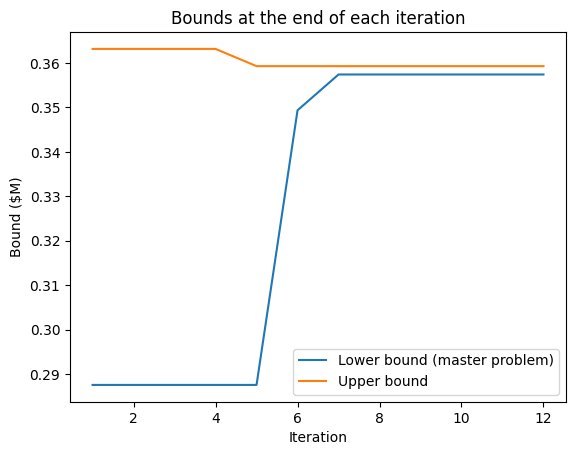

In [9]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot(range(1,len(LB_list)+1),np.array(LB_list)/10**6,range(1,len(LB_list)+1),np.array(UB_list)/10**6)
plt.title('Bounds at the end of each iteration')
plt.xlabel('Iteration')
plt.ylabel('Bound ($M)')
plt.legend(['Lower bound (master problem)','Upper bound'])
plt.savefig('Lag_cp.pdf')
plt.show()

In [10]:
Best_sol

{1: 1876.2082857142855, 2: 1619.0285714285715}